<a href="https://colab.research.google.com/github/JiatingLi/CNN_SoybeanIDC/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# for data reading
import pandas as pd
import numpy as np
from keras_preprocessing.image import ImageDataGenerator

# for model architecture
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam

# for plotting
from matplotlib import pyplot as plt

# for prediction evaluation
import math
from scipy import stats
from sklearn.metrics import mean_squared_error

# for saving files
from pandas import DataFrame

In [15]:
#### DATA PREPARATION
training_dir = '/content/drive/MyDrive/SoybeanIDC_CNN_Data/Valley711_RIL/' ##NEED TO refine directory for your own case
testing_dir = '/content/drive/MyDrive/SoybeanIDC_CNN_Data/Valley711_NAM/'

training_label_dir ='/content/drive/MyDrive/SoybeanIDC_CNN_Data/Valley711_RIL.csv'
testing_label_dir = '/content/drive/MyDrive/SoybeanIDC_CNN_Data/Valley711_NAM.csv'
training_label = pd.read_csv(training_label_dir, delimiter=',', header=0, names=['filename', 'IDC'])
testing_label = pd.read_csv(testing_label_dir, delimiter=',', header=0, names=['filename', 'IDC'])

testing_y = np.array(testing_label['IDC']) #true IDC scores for testing dataset

img_width, img_height = 224, 448 

## Read data using flow_from_dataframe()
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.2)
test_datagen=ImageDataGenerator(rescale=1./255.)

train_generator=datagen.flow_from_dataframe(
    dataframe=training_label,
    directory=training_dir,
    x_col='filename', 
    y_col='IDC',
    subset="training",
    batch_size=32,
    seed=22,
    shuffle=True,
    class_mode='raw',
    target_size=(img_height,img_width))

valid_generator=datagen.flow_from_dataframe(
    dataframe=training_label,
    directory=training_dir,
    x_col='filename', 
    y_col='IDC',
    subset="validation",
    batch_size=32,
    seed=22,
    shuffle=True,
    class_mode="raw",
    target_size=(img_height,img_width))

test_generator=test_datagen.flow_from_dataframe(
    dataframe=testing_label,
    directory=testing_dir,
    x_col="filename",
    y_col=None,
    batch_size=1,
    seed=22,
    shuffle=False,
    class_mode=None,
    target_size=(img_height,img_width))

Found 523 validated image filenames.
Found 130 validated image filenames.
Found 164 validated image filenames.


In [16]:
#### Define Model
inChannel = 3
input_img = Input(shape = (img_height, img_width, inChannel))

def regres(input_img):
    x = Conv2D(filters=16, kernel_size=3, activation='relu', padding='same')(input_img) 
    x = MaxPooling2D(pool_size=(2, 2))(x) 
    
    x = Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(x) 
    x = MaxPooling2D(pool_size=(2, 2))(x) 
     
    x = Flatten()(x)
    x = Dense(units=100, activation='relu')(x)

    #The output layer. Use 'softmax' or 'sigmoid' activation if your task is classification problem
    pred = Dense(units=1, activation='linear')(x) 
    return pred 


full_model = Model(input_img,regres(input_img))

full_model.summary()

full_model.compile(loss='mean_squared_error', metrics=['mean_squared_error'], optimizer=Adam(lr=0.0001))

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 448, 224, 3)]     0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 448, 224, 16)      448       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 224, 112, 16)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 224, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 112, 56, 32)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 200704)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               2007

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
16/16 [==============================] - 4s 199ms/step - loss: 5.5623 - mean_squared_error: 5.5623 - val_loss: 1.5425 - val_mean_squared_error: 1.5425
Epoch 2/100
16/16 [==============================] - 3s 177ms/step - loss: 1.0256 - mean_squared_error: 1.0256 - val_loss: 1.8638 - val_mean_squared_error: 1.8638
Epoch 3/100
16/16 [==============================] - 3s 174ms/step - loss: 0.8805 - mean_squared_error: 0.8805 - val_loss: 1.3216 - val_mean_squared_error: 1.3216
Epoch 4/100
16/16 [==============================] - 3s 178ms/step - loss: 0.7649 - mean_squared_error: 0.7649 - val_loss: 1.3336 - val_mean_squared_error: 1.3336
Epoch 5/100
16/16 [==============================] - 3s 176ms/step - loss: 0.5520 - mean_squared_error: 0.5520 - val_loss: 0.8683 - val_mean_squared_error: 0.8683
Epoch 6/100
16/16 [==============================] - 3s 174ms/step - loss: 0.5006 - mean_squared_error: 0.5006 - val_loss: 1.0460 - val_mean_squared_error: 1.0460
Epoch 7/100
16/16 [===

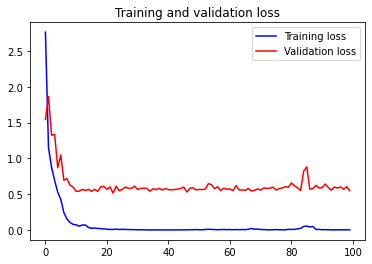

In [17]:
#### TRAIN model
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

regressor = full_model.fit_generator(generator=train_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=valid_generator,
                                     validation_steps=STEP_SIZE_VALID,
                                     epochs=100)

## plot training process
loss = regressor.history['loss']
val_loss = regressor.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

 12/164 [=>............................] - ETA: 0s 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


164/164 [==============================] - 1s 5ms/step
R2: 0.655629
RMSE: 1.444152


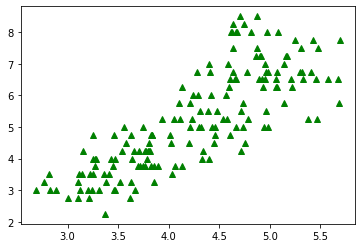

In [18]:
#### PREDICTION
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()

predict=full_model.predict_generator(test_generator,steps=STEP_SIZE_TEST,verbose=1)

# plot results
pred = predict[:,0]
true = testing_y
plt.plot(pred,true, 'g^')

# r2 and rmse 
slope, intercept, r_value, p_value, std_err = stats.linregress(true, pred) #x,y
mse = mean_squared_error(true, pred)
rmse = math.sqrt(mse)
print("R2: %f" % r_value**2)
print("RMSE: %f" % rmse)

# ## save
# df = DataFrame([true,pred])
# df = df.T #transpose
# df.to_excel('PATH TO EXPECTED DIRECTORY.xlsx', index=False)